In [0]:
"""
Bitcoin Price Forecasting with ARIMA  
Spring 2025 - DATA605 Final Project 
Author: Ritik | UMD | Databricks CLI Automation
"""
# Config
DBFS_DATA_PATH = "dbfs:/bitcoin/bitcoin_price.json"
DBFS_OUTPUT_PATH = "dbfs:/bitcoin/forecast_output.csv"
MODEL_ORDER = (1, 1, 1)
ARIMA_ORDER_CANDIDATES = [(1, 1, 1), (2, 1, 2), (0, 1, 1)]
# Libraries
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import logging
from pyspark.sql.types import StructType, StructField, TimestampType, DoubleType
from pyspark.sql.functions import from_json, col

# Logger setup
logging.basicConfig()
logger = logging.getLogger("bitcoin_forecast")
logger.setLevel(logging.INFO)
logger.info(" Libraries loaded and config set")

INFO:bitcoin_forecast: Libraries loaded and config set


In [0]:
def load_data(dbfs_path):
    """Load and validate raw data from DBFS"""
    try:
        raw_df = spark.read.text(dbfs_path)
        if raw_df.isEmpty():
            raise ValueError(f"No data found at {dbfs_path}")
        
        logger.info(f" Loaded {raw_df.count()} rows from DBFS")
        return raw_df
    except Exception as e:
        logger.error(f" Data loading failed: {str(e)}")
        raise

# Execute
raw_df = load_data(DBFS_DATA_PATH)
raw_df.show(5, truncate=False)



INFO:bitcoin_forecast: Loaded 1194 rows from DBFS


+-----------------------------------------------------------+
|value                                                      |
+-----------------------------------------------------------+
|{"timestamp": "2025-03-30T04:25:56.663227", "price": 83060}|
|{"timestamp": "2025-03-30T05:39:57.371254", "price": 83122}|
|{"timestamp": "2025-03-30T05:40:58.257615", "price": 83112}|
|{"timestamp": "2025-03-30T05:41:46.834078", "price": 83112}|
|{"timestamp": "2025-03-30T05:41:49.688149", "price": 83112}|
+-----------------------------------------------------------+
only showing top 5 rows



In [0]:
def clean_data(raw_df):
    try:
        schema = StructType([
            StructField("timestamp", TimestampType(), True),
            StructField("price",     DoubleType(),    True),
        ])

        parsed = (raw_df
            .select(from_json(col("value"), schema).alias("j"))
            .select("j.*")
            .na.drop(subset=["timestamp", "price"])
        )

        pdf = parsed.toPandas()
        if pdf.empty:
            raise ValueError("No valid JSON rows after parsing.")

        pdf["timestamp_naive"] = pdf["timestamp"].dt.tz_localize(None)
        before = len(pdf)
        pdf = pdf.dropna(subset=["price"])
        if pdf.empty:
            raise ValueError("All prices were NaN after dropna.")

        pdf = pdf.sort_values("timestamp_naive")
        pdf = pdf.drop_duplicates(subset="timestamp_naive", keep="last")
        pdf = pdf.set_index("timestamp_naive")

        if len(pdf) >= 2:
            pdf["price_change_pct"] = pdf["price"].pct_change()
        else:
            pdf["price_change_pct"] = pd.NA

        if len(pdf) >= 5:
            pdf["price_ma_5"] = pdf["price"].rolling(5).mean()
        else:
            pdf["price_ma_5"] = pd.NA

        pdf = pdf.dropna(subset=["price_change_pct"])

        return pdf[["price", "price_change_pct", "price_ma_5"]]

    except Exception as e:
        logger.error(f"clean_data failed: {e}", exc_info=True)
        raise

# Execute
pdf = clean_data(raw_df)
pdf.tail()



,price,price_change_pct,price_ma_5
timestamp_naive,,,
2025-05-01 01:29:56.541109,94646.0,0.003818,94473.2
2025-05-01 01:35:58.357366,94641.0,-0.000053,94474.4
2025-05-01 02:00:00.000000,94504.0,-0.001448,94463.4
2025-05-01 03:00:00.000000,94748.0,0.002582,94565.0
2025-05-02 02:16:47.250866,96840.0,0.022080,95075.8


/root/.ipykernel/966/command-7606466433313293-1119815140:14: UserWarning: Glyph 8383 (\N{BITCOIN SIGN}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8383 (\N{BITCOIN SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


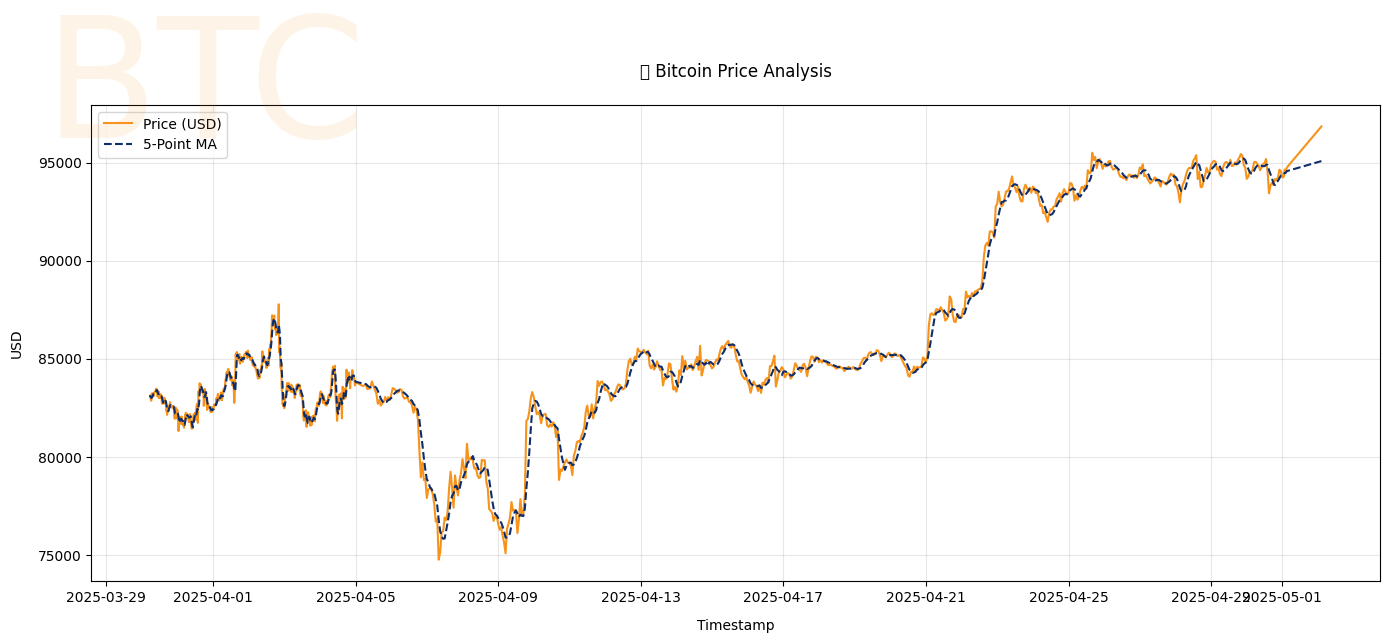

In [0]:
def plot_historical(data: pd.DataFrame):
    """Plot price history with moving average"""
    plt.figure(figsize=(14, 6))
    plt.plot(data.index, data['price'], label="Price (USD)", color="#F7931A")
    plt.plot(data.index, data['price_ma_5'], label="5-Point MA", linestyle="--", color="#0D2D6C")
    
    plt.title("₿ Bitcoin Price Analysis", pad=20)
    plt.xlabel("Timestamp", labelpad=10)
    plt.ylabel("USD", labelpad=10)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.figtext(0.15, 0.85, "BTC", fontsize=120, alpha=0.1, color="#F7931A", ha='center')
    plt.tight_layout()
    plt.show()

# Execute
plot_historical(pdf)




/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


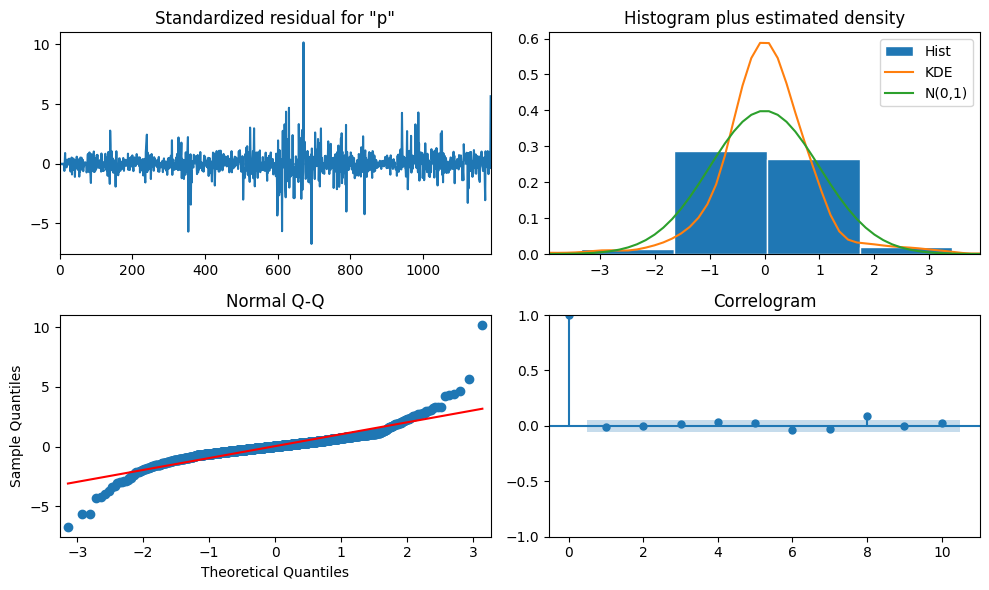

/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [0]:

def train_arima(data: pd.Series):
    """ARIMA training with manual order selection"""
    try:
        model = ARIMA(data, order=MODEL_ORDER).fit()
        
        orders = ARIMA_ORDER_CANDIDATES
        best_model = None
        best_order = None
        best_aic = np.inf

        for order in orders:
            try:
                trial_model = ARIMA(data, order=order).fit()
                trial_aic = trial_model.aic
                logger.info(f" Order {order} AIC: {trial_aic:.1f}")
                if trial_aic < best_aic:
                    best_model = trial_model
                    best_order = order
                    best_aic = trial_aic
            except Exception as e:
                logger.warning(f" ARIMA{order} failed: {e}")

        if best_model is None:
            raise RuntimeError("No valid ARIMA model could be fit.")

        logger.info(f" Selected ARIMA{best_order} | AIC: {best_aic:.1f}")
        return best_model, best_order
    except Exception as e:
        logger.error(f"ARIMA failed: {e}")
        raise RuntimeError("ARIMA model training failed. Check input data.")

model_fit, best_order = train_arima(pdf['price'])
model_fit.plot_diagnostics(figsize=(10, 6))
plt.tight_layout()
plt.show()
forecast_results = model_fit.get_forecast(steps=10)
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()



/root/.ipykernel/966/command-7606466433313295-1583194347:28: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


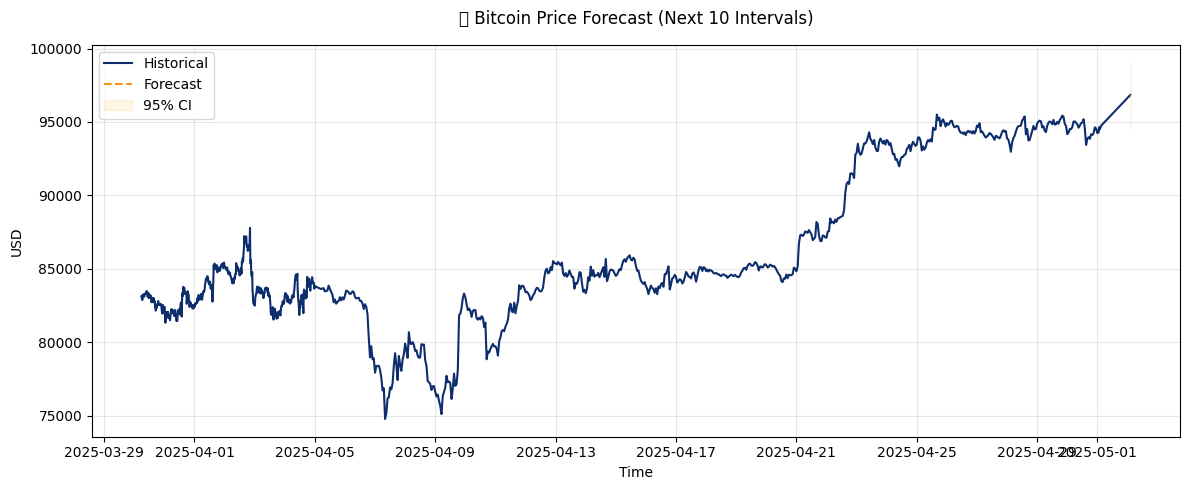

In [0]:
def plot_forecast(history: pd.DataFrame, forecast: pd.Series, conf_int=None):
    """Plot historical data + forecast"""
    future_index = pd.date_range(
        start=history.index[-1] + pd.Timedelta(minutes=1),
        periods=len(forecast),
        freq='T'
    )
    
    plt.figure(figsize=(12, 5))
    plt.plot(history.index, history['price'], label='Historical', color="#0D2D6C")
    plt.plot(future_index, forecast, label='Forecast', linestyle="--", color="#F7931A")
    
    if conf_int is not None:
        plt.fill_between(
            future_index,
            conf_int.iloc[:, 0],
            conf_int.iloc[:, 1],
            color='orange',
            alpha=0.1,
            label='95% CI'
        )
    
    plt.title('🔮 Bitcoin Price Forecast (Next 10 Intervals)', pad=15)
    plt.xlabel('Time')
    plt.ylabel('USD')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Execute
plot_forecast(pdf, forecast, forecast_results.conf_int())



In [0]:
def save_results(forecast: pd.Series, history: pd.DataFrame, model_order):
    """Save forecast to DBFS with metadata"""
    try:
        future_index = pd.date_range(
            start=history.index[-1] + pd.Timedelta(minutes=15),
            periods=len(forecast),
            freq='15T'
        )
        forecast_df = pd.DataFrame({
            'timestamp': future_index,
            'forecast_price': forecast,
            'model': str(model_order),
            'last_trained': pd.Timestamp.now().isoformat()
        })
        
        output_path = DBFS_OUTPUT_PATH.replace("dbfs:/", "/dbfs/")
        forecast_df.to_csv(output_path, index=False)
        logger.info(f" Saved forecast to {output_path}")
        
        # Verification
        assert len(dbutils.fs.ls("dbfs:/bitcoin/")) > 0, "DBFS write failed"
        logger.info(" DBFS write verified")
    except Exception as e:
        logger.error(f" Failed to save results: {str(e)}")
        raise

# Execute
save_results(forecast, pdf, best_order)



INFO:bitcoin_forecast: Saved forecast to /dbfs/bitcoin/forecast_output.csv
INFO:bitcoin_forecast: DBFS write verified


In [0]:
# Validation
assert not pdf.empty, "DataFrame should not be empty"
assert pdf.index.is_unique, "Timestamps contain duplicates"
assert pdf['price'].isna().sum() == 0, "Missing price values detected"
logger.info(" All data validation tests passed")

# Show output
display(dbutils.fs.ls("dbfs:/bitcoin/"))


INFO:bitcoin_forecast: All data validation tests passed


path,name,size,modificationTime
dbfs:/bitcoin/bitcoin_price.json,bitcoin_price.json,72540,1746152257000
dbfs:/bitcoin/forecast_output.csv,forecast_output.csv,884,1746153085000
